Continuous waveform mode
========================
In this tutorial, we will showcase continuous waveform mode (see [Continuous waveform mode](https://qblox-qblox-instruments.readthedocs-hosted.com/en/main/cluster/q1_sequence_processor.html#continuous-waveform-mode)) by observing the output on an oscilloscope to illustrate the results.

This tutorial is meant for a Cluster QCM, but can be applied also to a QRM module with the opportune modifications.

Setup
-----

First, we are going to import the required packages.

In [1]:

from __future__ import annotations

import json
import math
from typing import TYPE_CHECKING, Callable

import matplotlib.pyplot as plt
import numpy as np
import scipy.signal
from qcodes.instrument import find_or_create_instrument

from qblox_instruments import Cluster, ClusterType

if TYPE_CHECKING:
    from qblox_instruments.qcodes_drivers.module import QcmQrm

### Scan For Clusters

We scan for the available devices connected via ethernet using the Plug & Play functionality of the Qblox Instruments package (see [Plug & Play](https://qblox-qblox-instruments.readthedocs-hosted.com/en/main/api_reference/tools.html#api-pnp) for more info).

In [2]:
!qblox-pnp list

Devices:
 - 10.10.200.13 via 192.168.207.146/24 (reconfiguration needed!): cluster_mm 0.6.2 with name "QSE_1" and serial number 00015_2321_005
 - 10.10.200.42 via 192.168.207.146/24 (reconfiguration needed!): cluster_mm 0.7.0 with name "QAE-I" and serial number 00015_2321_004
 - 10.10.200.43 via 192.168.207.146/24 (reconfiguration needed!): cluster_mm 0.6.2 with name "QAE-2" and serial number 00015_2206_003
 - 10.10.200.50 via 192.168.207.146/24 (reconfiguration needed!): cluster_mm 0.7.0 with name "cluster-mm" and serial number 00015_2219_003
 - 10.10.200.53 via 192.168.207.146/24 (reconfiguration needed!): cluster_mm 0.7.0 with name "cluster-mm" and serial number 00015_2320_004
 - 10.10.200.70 via 192.168.207.146/24 (reconfiguration needed!): cluster_mm 0.6.1 with name "cluster-mm" and serial number 123-456-789
 - 10.10.200.80 via 192.168.207.146/24 (reconfiguration needed!): cluster_mm 0.6.1 with name "cluster-mm" and serial number not_valid


In [3]:
cluster_ip = "10.10.200.42"
cluster_name = "cluster0"

### Connect to Cluster

We now make a connection with the Cluster.

In [4]:

cluster = find_or_create_instrument(
    Cluster,
    recreate=True,
    name=cluster_name,
    identifier=cluster_ip,
    dummy_cfg=(
        {
            2: ClusterType.CLUSTER_QCM,
            4: ClusterType.CLUSTER_QRM,
            6: ClusterType.CLUSTER_QCM_RF,
            8: ClusterType.CLUSTER_QRM_RF,
        }
        if cluster_ip is None
        else None
    ),
)

#### Get connected modules

In [5]:
def get_connected_modules(cluster: Cluster, filter_fn: Callable | None = None) -> dict[int, QcmQrm]:
    def checked_filter_fn(mod: ClusterType) -> bool:
        if filter_fn is not None:
            return filter_fn(mod)
        return True

    return {
        mod.slot_idx: mod for mod in cluster.modules if mod.present() and checked_filter_fn(mod)
    }

In [6]:
# QCM or QRM baseband modules
modules = get_connected_modules(cluster, lambda mod: not mod.is_rf_type)
modules

{2: <Module: cluster0_module2 of Cluster: cluster0>,
 4: <Module: cluster0_module4 of Cluster: cluster0>}

In [7]:
module = modules[4]

### Reset the Cluster

We reset the Cluster to enter a well-defined state. Note that resetting will clear all stored parameters, so resetting between experiments is usually not desirable.

In [8]:
cluster.reset()
print(cluster.get_system_state())

Status: OKAY, Flags: NONE, Slot flags: NONE


c:\work\code\qblox_instruments_install\qblox_instruments\native\generic_func.py:1033: FutureWarning: 
        After June 2024, this feature is subject to removal in future releases.
        Transition to an alternative is advised.
        See https://qblox-qblox-instruments.readthedocs-hosted.com/en/main/getting_started/deprecated.html
        
  warnings.warn(
c:\work\code\qblox_instruments_install\qblox_instruments\native\generic_func.py:77: FutureWarning: 
            After June 2024, this feature is subject to removal in future releases.
            Transition to an alternative is advised.
            See https://qblox-qblox-instruments.readthedocs-hosted.com/en/main/getting_started/deprecated.html
            
  self._deprecation_warning()
c:\work\code\qblox_instruments_install\qblox_instruments\native\generic_func.py:129: FutureWarning: 
            After June 2024, this feature is subject to removal in future releases.
            Transition to an alternative is advised.
       

<a id='gen_wf'>Generate waveforms</a>
------------------

Next, we are going to generate a couple of waveforms that we are going to upload to the instrument in the next step.

In [9]:
# Waveform parameters
waveform_length = 120  # nanoseconds (needs to be a minimum of 4 ns)

# Waveform dictionary (data will hold the samples and index will be used to select the waveforms in the instrument).
waveforms = {
    "gaussian": {
        "data": scipy.signal.windows.gaussian(waveform_length, std=0.12 * waveform_length).tolist(),
        "index": 0,
    },
    "sine": {
        "data": [math.sin((2 * math.pi / waveform_length) * i) for i in range(0, waveform_length)],
        "index": 1,
    },
    "sawtooth": {
        "data": [(1.0 / (waveform_length)) * i for i in range(0, waveform_length)],
        "index": 2,
    },
    "block": {"data": [1.0 for i in range(0, waveform_length)], "index": 3},
}

Let's plot the waveforms to see what we have created.

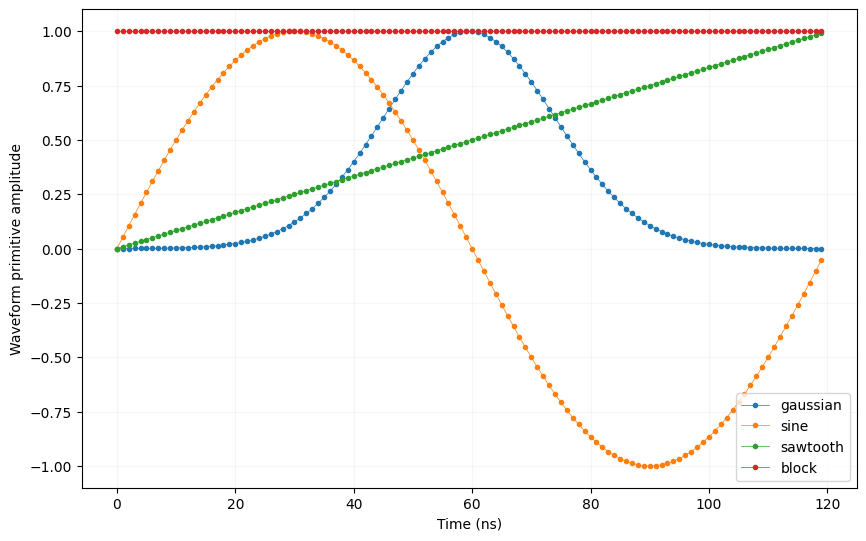

In [10]:
time = np.arange(0, max(map(lambda d: len(d["data"]), waveforms.values())), 1)
fig, ax = plt.subplots(1, 1, figsize=(10, 10 / 1.61))

for wf, d in waveforms.items():
    ax.plot(time[: len(d["data"])], d["data"], ".-", linewidth=0.5, label=wf)

ax.legend(loc=4)
ax.grid(alpha=1 / 10)
ax.set_ylabel("Waveform primitive amplitude")
ax.set_xlabel("Time (ns)")

plt.draw()
plt.show()

Upload waveforms
----------------

Now that we know that the waveforms are what we expect them to be, let's upload them to the instrument.
To do this we need to store the waveforms in a JSON file together with a Q1ASM program for the sequence
processor. Since we are going to use continuous waveform mode, the sequence processor will be bypassed
and the Q1ASM program can be trivial (i.e. `stop`).

In [11]:
# Sequence program.
seq_prog = "stop"

# Check waveform length.
for name in waveforms:
    assert (
        len(waveforms[name]["data"]) % 4
    ) == 0, "In continuous waveform mode the length of a waveform must be a multiple of 4!"

# Add sequence program and waveforms to single dictionary and write to JSON file.
sequence = {
    "waveforms": waveforms,
    "weights": {},
    "acquisitions": {},
    "program": seq_prog,
}
with open("cont_wave_mode_sequence.json", "w", encoding="utf-8") as file:
    json.dump(sequence, file, indent=4)
    file.close()

Let's write the JSON file to the instruments. We will use sequencer 0 and 1, which will drive outputs $\text{O}^{[1-2]}$ and $\text{O}^{[3-4]}$ respectively.

In [12]:
# Upload sequence.
module.sequencer0.sequence("cont_wave_mode_sequence.json")
module.sequencer1.sequence("cont_wave_mode_sequence.json")

Play waveforms
--------------

The waveforms have been uploaded to the instrument. Now we need to configure the instrument to run in continuous waveform mode. We
do this by setting the following parameters of the sequencers.

In [13]:
# Configure the sequencers to run in continuous waveform mode.
for sequencer in [module.sequencer0, module.sequencer1]:
    sequencer.cont_mode_en_awg_path0(True)
    sequencer.cont_mode_en_awg_path1(True)

# Map sequencers to specific outputs (but first disable all sequencer connections).
module.disconnect_outputs()

# If it is a QRM, we only map sequencer 0 to the outputs.
module.sequencer0.connect_sequencer("out0_1")
if module.is_qcm_type:
    module.sequencer1.connect_sequencer("out2_3")

# Set specific waveform to specific output.
module.sequencer0.cont_mode_waveform_idx_awg_path0(0)  # Gaussian on O1
module.sequencer0.cont_mode_waveform_idx_awg_path1(1)  # Sine on O2
module.sequencer1.cont_mode_waveform_idx_awg_path0(2)  # Sawtooth on 03
module.sequencer1.cont_mode_waveform_idx_awg_path1(3)  # DC on O4

Now let's start playback.

In [14]:
# Arm and start both sequencers.
module.arm_sequencer(0)
module.arm_sequencer(1)
module.start_sequencer()

# Print status of both sequencers (should now say Q1 stopped, because of the stop instruction).
print(module.get_sequencer_state(0))
print(module.get_sequencer_state(1))

Status: STOPPED, Flags: NONE
Status: STOPPED, Flags: NONE


c:\work\code\qblox_instruments_install\qblox_instruments\native\generic_func.py:2414: FutureWarning: 
        After June 2024, this feature is subject to removal in future releases.
        Transition to an alternative is advised.
        See https://qblox-qblox-instruments.readthedocs-hosted.com/en/main/getting_started/deprecated.html
        
  warnings.warn(
c:\work\code\qblox_instruments_install\qblox_instruments\native\generic_func.py:85: FutureWarning: 
            After June 2024, this feature is subject to removal in future releases.
            Transition to an alternative is advised.
            See https://qblox-qblox-instruments.readthedocs-hosted.com/en/main/getting_started/deprecated.html
            
  self._deprecation_warning()


Check waveforms
---------------

The instrument is now running in continuous waveform mode. Now let's connect an oscilloscope and check the outputs.
We connect all output channels of the QXM to two/four channels of an oscilloscope.
On the scope we are able to see that all waveforms are being generated correctly:

[![continuous waveform mode scope image](cont_waveform_scope.png)](cont_waveform_scope.png)

Outputs: Yellow=$\text{O}^{1}$, Blue=$\text{O}^{2}$, Purple=$\text{O}^{3}$ and Green=$\text{O}^{4}$

Stop
----

Finally, let's stop the sequencers if they haven't already and close the instrument connection. One can also display a detailed snapshot containing the instrument parameters before
closing the connection by uncommenting the corresponding lines.

In [15]:
# Stop both sequencers.
module.stop_sequencer()

# Print status of both sequencers (should now say it is stopped).
print(module.get_sequencer_state(0))

# Uncomment the following to print an overview of the instrument parameters.
print("Snapshot:")
module.print_readable_snapshot(update=True)

# Reset the cluster
cluster.reset()
print(cluster.get_system_state())

Status: STOPPED, Flags: FORCED_STOP
Snapshot:


cluster0_module4:
	parameter                    value
--------------------------------------------------------------------------------
in0_gain                      :	-6 (dB)
in0_offset                    :	0 (V)
in1_gain                      :	-6 (dB)
in1_offset                    :	0 (V)
marker0_inv_en                :	False 
marker1_inv_en                :	False 
marker2_inv_en                :	False 
marker3_inv_en                :	False 
out0_offset                   :	0 (V)
out1_offset                   :	0 (V)
present                       :	True 
scope_acq_avg_mode_en_path0   :	False 
scope_acq_avg_mode_en_path1   :	False 
scope_acq_sequencer_select    :	0 
scope_acq_trigger_level_path0 :	0 
scope_acq_trigger_level_path1 :	0 
scope_acq_trigger_mode_path0  :	sequencer 
scope_acq_trigger_mode_path1  :	sequencer 


cluster0_module4_sequencer0:
	parameter                       value
--------------------------------------------------------------------------------
connect_acq_I                    :	in0 
connect_acq_Q                    :	in1 
connect_out0                     :	I 
connect_out1                     :	Q 
cont_mode_en_awg_path0           :	True 
cont_mode_en_awg_path1           :	True 
cont_mode_waveform_idx_awg_path0 :	0 
cont_mode_waveform_idx_awg_path1 :	1 
demod_en_acq                     :	False 
gain_awg_path0                   :	1 
gain_awg_path1                   :	1 
integration_length_acq           :	1024 
marker_ovr_en                    :	False 
marker_ovr_value                 :	0 
mixer_corr_gain_ratio            :	1 
mixer_corr_phase_offset_degree   :	-0 
mod_en_awg                       :	False 
nco_freq                         :	0 (Hz)
nco_phase_offs                   :	0 (Degrees)
nco_prop_delay_comp              :	0 (ns)
nco_prop_delay_comp_en           :	False (ns)
of

cluster0_module4_sequencer1:
	parameter                       value
--------------------------------------------------------------------------------
connect_acq_I                    :	in0 
connect_acq_Q                    :	in1 
connect_out0                     :	off 
connect_out1                     :	off 
cont_mode_en_awg_path0           :	True 
cont_mode_en_awg_path1           :	True 
cont_mode_waveform_idx_awg_path0 :	2 
cont_mode_waveform_idx_awg_path1 :	3 
demod_en_acq                     :	False 
gain_awg_path0                   :	1 
gain_awg_path1                   :	1 
integration_length_acq           :	1024 
marker_ovr_en                    :	False 
marker_ovr_value                 :	0 
mixer_corr_gain_ratio            :	1 
mixer_corr_phase_offset_degree   :	-0 
mod_en_awg                       :	False 
nco_freq                         :	0 (Hz)
nco_phase_offs                   :	0 (Degrees)
nco_prop_delay_comp              :	0 (ns)
nco_prop_delay_comp_en           :	False (ns

cluster0_module4_sequencer2:
	parameter                       value
--------------------------------------------------------------------------------
connect_acq_I                    :	in0 
connect_acq_Q                    :	in1 
connect_out0                     :	off 
connect_out1                     :	off 
cont_mode_en_awg_path0           :	False 
cont_mode_en_awg_path1           :	False 
cont_mode_waveform_idx_awg_path0 :	0 
cont_mode_waveform_idx_awg_path1 :	0 
demod_en_acq                     :	False 
gain_awg_path0                   :	1 
gain_awg_path1                   :	1 
integration_length_acq           :	1024 
marker_ovr_en                    :	False 
marker_ovr_value                 :	0 
mixer_corr_gain_ratio            :	1 
mixer_corr_phase_offset_degree   :	-0 
mod_en_awg                       :	False 
nco_freq                         :	0 (Hz)
nco_phase_offs                   :	0 (Degrees)
nco_prop_delay_comp              :	0 (ns)
nco_prop_delay_comp_en           :	False (

cluster0_module4_sequencer3:
	parameter                       value
--------------------------------------------------------------------------------
connect_acq_I                    :	in0 
connect_acq_Q                    :	in1 
connect_out0                     :	off 
connect_out1                     :	off 
cont_mode_en_awg_path0           :	False 
cont_mode_en_awg_path1           :	False 
cont_mode_waveform_idx_awg_path0 :	0 
cont_mode_waveform_idx_awg_path1 :	0 
demod_en_acq                     :	False 
gain_awg_path0                   :	1 
gain_awg_path1                   :	1 
integration_length_acq           :	1024 
marker_ovr_en                    :	False 
marker_ovr_value                 :	0 
mixer_corr_gain_ratio            :	1 
mixer_corr_phase_offset_degree   :	-0 
mod_en_awg                       :	False 
nco_freq                         :	0 (Hz)
nco_phase_offs                   :	0 (Degrees)
nco_prop_delay_comp              :	0 (ns)
nco_prop_delay_comp_en           :	False (

cluster0_module4_sequencer4:
	parameter                       value
--------------------------------------------------------------------------------
connect_acq_I                    :	in0 
connect_acq_Q                    :	in1 
connect_out0                     :	off 
connect_out1                     :	off 
cont_mode_en_awg_path0           :	False 
cont_mode_en_awg_path1           :	False 
cont_mode_waveform_idx_awg_path0 :	0 
cont_mode_waveform_idx_awg_path1 :	0 
demod_en_acq                     :	False 
gain_awg_path0                   :	1 
gain_awg_path1                   :	1 
integration_length_acq           :	1024 
marker_ovr_en                    :	False 
marker_ovr_value                 :	0 
mixer_corr_gain_ratio            :	1 
mixer_corr_phase_offset_degree   :	-0 
mod_en_awg                       :	False 
nco_freq                         :	0 (Hz)
nco_phase_offs                   :	0 (Degrees)
nco_prop_delay_comp              :	0 (ns)
nco_prop_delay_comp_en           :	False (

cluster0_module4_sequencer5:
	parameter                       value
--------------------------------------------------------------------------------
connect_acq_I                    :	in0 
connect_acq_Q                    :	in1 
connect_out0                     :	off 
connect_out1                     :	off 
cont_mode_en_awg_path0           :	False 
cont_mode_en_awg_path1           :	False 
cont_mode_waveform_idx_awg_path0 :	0 
cont_mode_waveform_idx_awg_path1 :	0 
demod_en_acq                     :	False 
gain_awg_path0                   :	1 
gain_awg_path1                   :	1 
integration_length_acq           :	1024 
marker_ovr_en                    :	False 
marker_ovr_value                 :	0 
mixer_corr_gain_ratio            :	1 
mixer_corr_phase_offset_degree   :	-0 
mod_en_awg                       :	False 
nco_freq                         :	0 (Hz)
nco_phase_offs                   :	0 (Degrees)
nco_prop_delay_comp              :	0 (ns)
nco_prop_delay_comp_en           :	False (

Status: OKAY, Flags: NONE, Slot flags: NONE
